## Project 2 : Advanced lane finding

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from collections import deque
%matplotlib inline

### 1、 Extract object points and image points for camera calibration.  

In [1]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

### 2、Use `objpoints` and `imgpoints`  to calibrate, calculate distortion coefficients, and test undistortion on an image!

Text(0.5,1,'Undistorted Image')

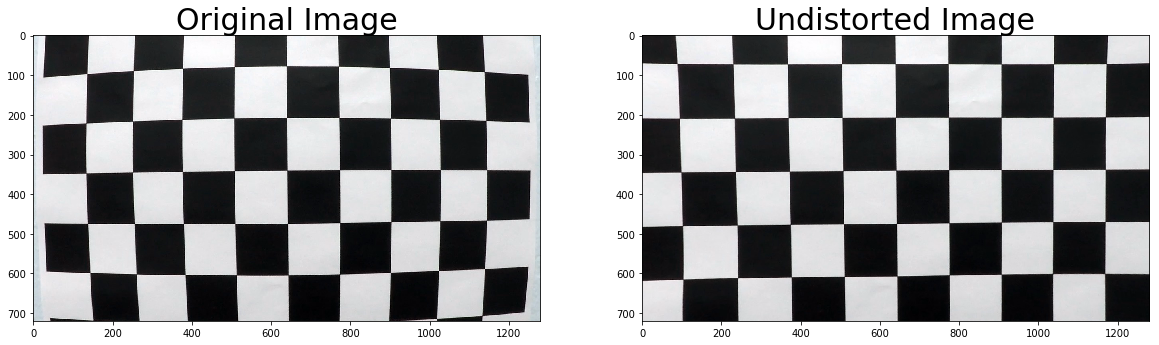

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### 3、 Use distortion coefficients 'mtx' , 'dist' to undistortion  raw images.

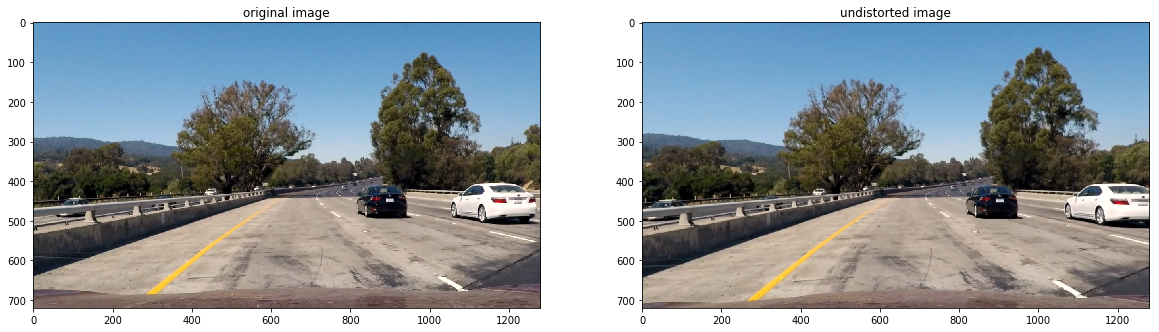

In [3]:
def udis_image(image):
    dist_pickle = pickle.load( open( "camera_cal/dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

im_img = mpimg.imread('test_images/test1.jpg')
undis_img = udis_image(im_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('original image')
ax1.imshow(im_img)

ax2.set_title('undistorted image')
ax2.imshow(undis_img, cmap='gray')

### 4、Use color transforms, gradients, etc., to create a thresholded binary image.

In [147]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 5) Return this mask as your binary_output image
    return sxbinary

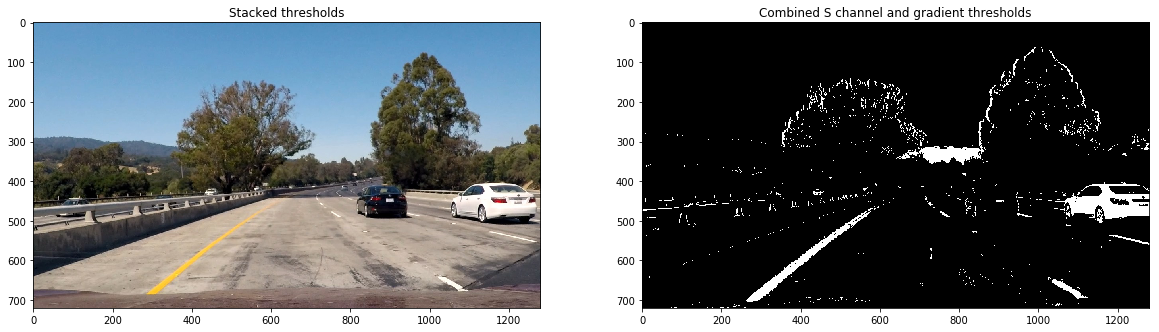

In [163]:
def bin_image(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    light_mask = np.zeros_like(l_channel)
    light_mask[(s_channel >= 5) & (l_channel >= 130)] = 1
    
    r_channel = image[:,:,0]
    g_channel = image[:,:,1]
    b_channel = image[:,:,2]    
    w_mask = np.zeros_like(l_channel)
    w_mask[(r_channel >= 190) & (g_channel >=190) & (b_channel >= 190)] = 1
    
    y_mask = np.zeros_like(l_channel)
    y_mask[(r_channel >= 110) & (g_channel >= 110) & (b_channel <= 100)] = 1
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    ksize = 3
    gradx_l = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=ksize, thresh=(35, 100))
    gradx_s = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(15, 100))
    gray_x =  abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 100))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gray)
    #combined_binary[(((gradx_l ==1 )|(gradx_s == 1)) & (light_mask == 1))|((w_mask ==1) & (gray_x == 1))] = 1  
    #combined_binary[ (y_mask == 1) & (gray_x == 1)] = 1  
    combined_binary[(((gradx_l ==1 )|(gradx_s == 1)) & (light_mask == 1))|((y_mask ==1)| (w_mask ==1))] = 1 
    
    #combined_binary[(y_mask ==1)] = 1
    
    return combined_binary

bin_img = bin_image(undis_img)

    # Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(im_img)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(bin_img, cmap='gray')

### 5、Use  perspective transform to rectify binary image

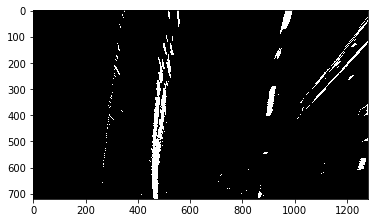

In [164]:
def warp_image(binary_image):
    src = np.float32([[435, 560],[860, 560],[1025, 660],[295, 660]])
    #dst = np.float32([[450, 418],[850, 418],[850, 700],[450, 700]])
    dst = np.float32([[450, 610],[850, 610],[850, 700],[450, 700]])
    
    img_size = (binary_image.shape[1], binary_image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(binary_image, M, img_size)
    return warped, Minv

warp_img, Minv = warp_image(bin_img)
plt.imshow(warp_img,  cmap='gray')

### 6、Find lane pixels and fit to find the lane boundary

In [142]:
def find_lane_slide(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[350:,:], axis=0)
    # Create an output image to draw on and visualize the result
    
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[300:midpoint]) + 300
    rightx_base = np.argmax(histogram[midpoint:1150]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high) & (nonzerox >= 350) & (nonzerox < 660)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high) & (nonzerox >= 800) & (nonzerox < 1050)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        else:
            rightx_current = leftx_current+400

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

In [105]:
def search_around_poly(binary_warped, left_x_points, left_y_points, right_x_points, right_y_points):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin =50

    left_fit = np.polyfit(left_y_points, left_x_points, 2)
    right_fit = np.polyfit(right_y_points, right_x_points, 2)
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)) & (nonzerox >= 350) & (nonzerox < 660))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)) & (nonzerox >= 800) & (nonzerox < 1050))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty


In [8]:
def get_lane_points(binary_warped, left_x_points = None, left_y_points = None, right_x_points = None, right_y_points = None, fail_count = 0):
    
    max_failures = 2
    
    # If we don't have any previous results, perform full search
    if ((left_x_points == None) | (left_y_points == None) |  (right_x_points== None) | (right_y_points == None)):
        leftx, lefty, rightx, righty = find_lane_slide(binary_warped)
        if is_good_points(leftx, lefty, rightx, righty) == False:
            fail_count += 1
        else:
            fail_count = 0
        return leftx, lefty, rightx, righty, fail_count
    
    else:
        # If we do have previous lanes findings, try to find lanes nearby
        leftx, lefty, rightx, righty = search_around_poly(binary_warped, left_x_points, left_y_points, right_x_points, right_y_points)
        
        # If what we found nearby are a good scoring lanes, keep them
        if is_good_points(leftx, lefty, rightx, righty) == True:
            return leftx, lefty, rightx, righty, 0
        else:
            # If we have relatively few failres, return found points
            if fail_count < max_failures:
                return leftx, lefty, rightx, righty, fail_count + 1
            
            # Otehrwise perform the full search
            leftx, lefty, rightx, righty = find_lane_slide(binary_warped)
            
            if not good_points:
                # We had failures before, and failed again. Keep trying.
                fail_count = max_failures
            else:
                fail_count = 0
            return leftx, lefty, rightx, righty, fail_count

In [9]:
def is_good_points(leftx, lefty, rightx, righty):
    if len(leftx) == 0 or len(rightx) == 0:
        return False
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    if abs(left_fit[0] - right_fit[0])> 0.005 or abs(left_fit[2] - right_fit[2]-400)>60:
        return False
    return True

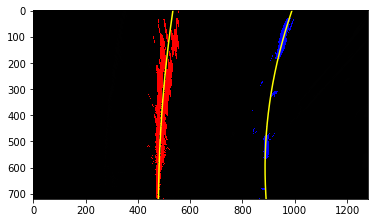

In [110]:
def fit_polynomial(binary_warped, leftx, lefty, rightx, righty ):
    # Find our lane pixels first
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    #leftx, lefty, rightx, righty, out_img = find_lane_slide(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
                
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    return out_img, left_fitx, right_fitx, ploty

# Plots the left and right polynomials on the lane lines
leftx, lefty, rightx, righty = find_lane_slide(warp_img)
out_img, left_fitx, right_fitx, ploty = fit_polynomial(warp_img, leftx, lefty, rightx, righty)
plt.plot(left_fitx, ploty,  color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)

### 7、Determine the curvature of the lane and vehicle position from the center

In [11]:
def measure_curvature_pixels(binary_warped, leftx, lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    xm_per_pix = 3.7/400
    ym_per_pix = 3.0/90
    leftx = leftx*xm_per_pix
    rightx = rightx*xm_per_pix
    lefty = lefty*ym_per_pix
    righty = righty*ym_per_pix
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    ploty = ploty*ym_per_pix
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = np.sqrt((1+(2*left_fit[0]*y_eval+left_fit[1])**2)**3)/(2*abs(left_fit[0]))  ## Implement the calculation of the left line here
   # right_curverad = np.sqrt((1+(2*right_fit[0]*y_eval+right_fit[1])**2)**3)/(2*abs(right_fit[0]))  ## Implement the calculation of the right line here
    
    left_lane_position = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane_position = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    center_position = np.mean([left_lane_position, right_lane_position])
    center_ideal = binary_warped.shape[1] * xm_per_pix / 2.0
    distance_from_center = center_ideal - center_position
    
    return left_curverad, distance_from_center

### 8、Warp the detected lane boundaries back onto the original image

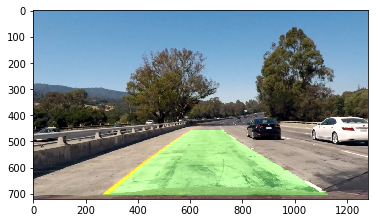

In [12]:
def inverse_wrap_lane(image, binary_warped, Minv, left_fitx, right_fitx, ploty):
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window1 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
    line_areas = np.hstack((left_line_window1, right_line_window1))

    window_img = np.zeros_like(binary_warped)
    cv2.fillPoly(window_img, np.int_([line_areas]), 1)
    
    img_size = (binary_warped.shape[1], binary_warped.shape[0])
    inverse_warped = cv2.warpPerspective(window_img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    R = np.zeros_like(binary_warped)
    out_img = np.dstack((R, inverse_warped, R))*255
    
    result = cv2.addWeighted(image, 1, out_img, 0.3, 0)
    
    return result

inver_img =  inverse_wrap_lane(undis_img, warp_img, Minv, left_fitx, right_fitx, ploty) 
plt.imshow(inver_img)

# Video

In [13]:
def find_lane_process(image, left_x_points = None, left_y_points = None, right_x_points = None, right_y_points = None, fail_count = 0, curvature_queue = deque([])):
    u_image = udis_image(image)
    b_image = bin_image(u_image)
    warped_1, Minv = warp_image(b_image)
    leftx, lefty, rightx, righty, fail_count = get_lane_points(warped_1, left_x_points = None, left_y_points = None, right_x_points = None, right_y_points = None, fail_count = 0)
    
    if len(leftx) == 0 or len(lefty) == 0 or len(rightx) == 0 or len(righty) == 0:
        return u_image, leftx, lefty, rightx, righty, fail_count
    
    out_img, left_fitx, right_fitx, ploty = fit_polynomial(warped_1, leftx, lefty, rightx, righty)

    # Calculate the radius of curvature in pixels for both lane lines
    curverad, distance_from_center = measure_curvature_pixels(warped_1, leftx, lefty, rightx, righty)
    inverse_warped = inverse_wrap_lane(u_image, warped_1, Minv, left_fitx, right_fitx, ploty)
    
    if len(curvature_queue) > 10:
        curvature_queue.popleft()
    
    curvature_queue.append(curverad)
    
    curverad_avarage = np.mean(curvature_queue)
    
    # Print curvature and center offset on an image
    stats_text = 'Curvature: {0:.0f}m, Center offset: {1:.1f}m'.format(curverad_avarage, \
                                                                distance_from_center)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(inverse_warped, stats_text, \
                (100, 600), \
                font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    return inverse_warped, leftx, lefty, rightx, righty, fail_count

In [14]:
def process_frame(image):
    global left_x_points, left_y_points, right_x_points, right_y_points, fail_count
    result, left_x_points, left_y_points, right_x_points, right_y_points, fail_count, = find_lane_process(image, \
                                                                                        left_x_points, \
                                                                                        left_y_points, \
                                                                                        right_x_points, \
                                                                                        right_y_points, \
                                                                                        fail_count)
                                                                                
    return result

In [165]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_x_points = None
left_y_points = None
right_x_points = None
right_y_points = None
fail_count = 0
curvature_queue = deque([])

white_output = 'output_images/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [06:12<00:00,  3.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 3min 13s, sys: 53.8 s, total: 4min 7s
Wall time: 6min 15s


In [162]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [151]:
white_output = 'output_images/challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


100%|██████████| 485/485 [02:17<00:00,  3.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

CPU times: user 1min 11s, sys: 20.7 s, total: 1min 32s
Wall time: 2min 20s


In [152]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))